In [1]:
import numpy as np
import torch
import os
from neural_verification import *
import matplotlib.pyplot as plt
import itertools
import copy

# This GeneralRNN has been defined in neural_verification, but I modified it:
# (1) comment out some assertions which throw out errors but aren't really errors?
# (2) Not only return hidden (last hidden states), but also hidden2 (second-to-last hidden states)
@dataclass
class GeneralRNNConfig:
    input_dim: int = 2
    output_dim: int = 1
    hidden_dim: int = 40
    hidden_mlp_depth: int = 2 # this would be 1 hidden layer
    hidden_mlp_width: int = 100
    output_mlp_depth: int = 2 # this would be 1 hidden layer
    output_mlp_width: int = 100
    activation: type = nn.SiLU

class GeneralRNN(nn.Module):
    def __init__(self, config, device='cpu'):
        super().__init__()
        self.config = config
        self.hidden_dim = config.hidden_dim
        hmlp_config = MLPConfig(
            config.hidden_dim + config.input_dim, 
            config.hidden_dim, 
            config.hidden_mlp_width, 
            config.hidden_mlp_depth, 
            config.activation
        )
        self.hmlp = MLP(hmlp_config).to(device)
        ymlp_config = MLPConfig(
            config.hidden_dim, 
            config.output_dim, 
            config.output_mlp_width, 
            config.output_mlp_depth, 
            config.activation
        )
        self.ymlp = MLP(ymlp_config).to(device)
        self.device = device

    def forward(self, x, h=None):
        """The transition is given by:
            h_t = f([h_{t-1}, x_t])
            y_t = g(h_t)
        where f and g are MLPs.

        This function takes in the input and the hidden state and 
        returns an output and a hidden state.
        """
        # x shape: (batch_size, input_dim)
        # h shape: (batch_size, hidden_dim)
        if h is None:
            h = torch.zeros(x.size(0), self.hidden_dim).to(self.device)
        else:
            assert h.size(0) == x.size(0)
            assert h.size(1) == self.hidden_dim
            #assert h.device == self.device
        assert x.size(1) == self.config.input_dim
        #assert x.device == self.device
        hx = torch.cat((h, x), dim=1)
        h = self.hmlp(hx)
        y = self.ymlp(h)
        return y, h
    
    def forward_sequence(self, x):
        """This function takes in a sequence of inputs and returns a sequence of outputs
        as well as the final hidden state."""
        # x shape: (batch_size, sequence_length, input_dim)
        batch_size = x.size(0)
        seq_length = x.size(1)
        hidden = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        assert x.size(2) == self.config.input_dim
        #assert x.device == self.device
        outs = []
        for i in range(seq_length):
            out, hidden = self.forward(x[:,i,:], hidden)
            if i == seq_length-2:
                hidden2 = hidden.clone()
            outs.append(out)
        # out shape: (batch_size, sequence_length, output_dim)
        return torch.stack(outs).permute(1,0,2), hidden, hidden2

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

data = torch.load("../tasks/rnn_sum_last2_numerical/data.pt")

config = torch.load("./rnn_models/rnn_sum_last2_numerical/model_config.pt", map_location=torch.device('cpu'))
model = GeneralRNN(config)
model.load_state_dict(torch.load("./rnn_models/rnn_sum_last2_numerical/model_perfect.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [2]:
hidden = model.forward_sequence(data[0].unsqueeze(dim=2))[1].cpu().detach().numpy()
hidden_last = model.forward_sequence(data[0].unsqueeze(dim=2))[2].cpu().detach().numpy()
D = hidden.shape[1]
thres = 1e-1

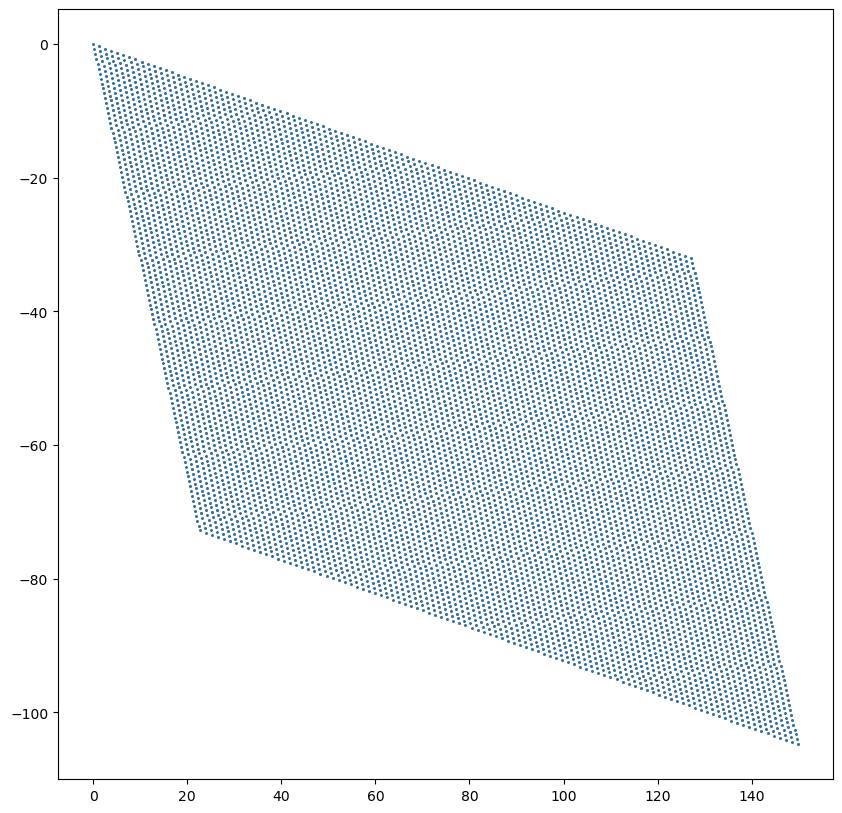

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(hidden[:,0], hidden[:,1], s=0.01)

In [4]:
def subset(arr, criterion=None, batch_size = 32):
    '''if arr contains too many samples, computation can be expensive.
    Choosing a subset of samples if usually enough for lattice detection.'''
    if criterion != None:
        arr = arr[np.where(criterion(arr))[0]]
    batch_id = np.random.choice(arr.shape[0], batch_size)
    arr = arr[batch_id]
    return arr 

def check_integer_arr(arr):
    non_integer = np.abs(arr - np.round(arr)) > thres
    all_integer = np.sum(non_integer) == 0
    return all_integer


def get_vol_arr(x):
    '''Given n points in R^D, return all possible volumes of D+1 points'''
    num = x.shape[0]
    groups = np.array(list(itertools.combinations(x, D+1)))
    groups = groups[:,1:,:] - groups[:,[0],:]
    vols = np.abs(np.linalg.det(np.array(groups)))
    return np.array(vols)


def GCD_2num_v(a, b, va, vb):
    while True:
        temp = a
        a = b
        b = temp

        temp = va
        va = vb
        vb = temp
        
        proj = np.round(a/b)
        a = a - proj * b
        va = va - proj * vb
        if np.abs(a) < thres:
            break
    return np.abs(b), vb

def GCD_arr(arr):
    vol_arr = get_vol_arr(arr)
    while True:
        va = arr[[0]]; vb = arr[[1]]; v3 = arr[2:D+1]
        a = np.linalg.det(np.concatenate([va, v3], axis=0))
        b = np.linalg.det(np.concatenate([vb, v3], axis=0))
        
        if b == 0 or a == 0:
            if b == 0:
                arr = np.delete(arr, 1, 0)
            if a == 0:
                arr = np.delete(arr, 0, 0)
            continue
        gcd, vbp = GCD_2num_v(a, b, va, vb)
        flag = check_integer_arr(vol_arr/gcd)
        if flag == True:
            break
        else:
            arr = arr[1:]
            arr[0] = vbp
    return np.concatenate([vbp, v3], axis=0)

def normalize_basis(basis):
    basis = copy.deepcopy(basis)
    ii = 0
    while True and ii < 5:
        projs = []
        for i in range(D):
            proj = np.round(np.sum(basis*basis[[i]],axis=1)/np.linalg.norm(basis[i])**2)
            proj[i] = 0
            basis -= proj[:,np.newaxis] * basis[[i]]
            projs.append(proj)
        projs = np.array(projs)
        if np.sum(np.abs(projs)) == 0:
            break
        ii += 1
    basis *= (-1)**(np.sum(basis, axis=1)<0)[:,np.newaxis]
    return basis

In [5]:
hidden_batch = subset(hidden, criterion=lambda x: x[:,0] + x[:,1] < -45)
shift = copy.deepcopy(hidden_batch[[np.argmin(np.sum(hidden_batch, axis=1))]])
hidden_batch_shift = hidden_batch - shift
basis_comp = GCD_arr(copy.deepcopy(hidden_batch_shift))
basis_comp = normalize_basis(basis_comp)

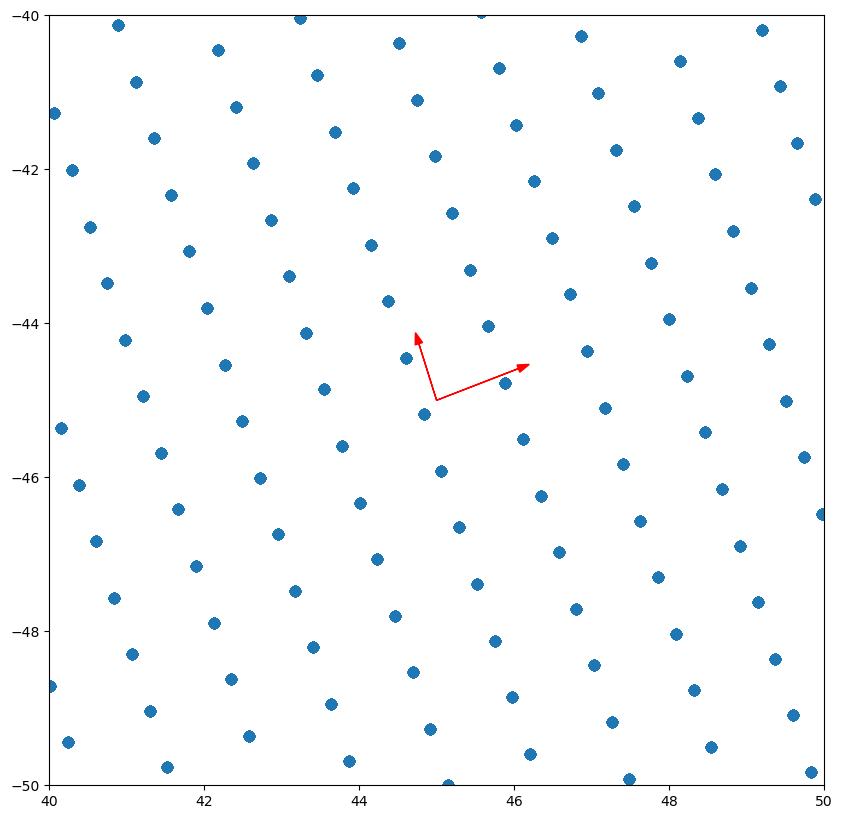

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(hidden[:,0], hidden[:,1], s=50)
plt.xlim(40,50)
plt.ylim(-50,-40)

for i in range(2):
    plt.arrow(45,-45,basis_comp[i][0], basis_comp[i][1], color="red", head_width=0.1)

In [7]:
h_int_lattice = np.matmul(hidden - shift, np.linalg.inv(basis_comp))
h_last_int_lattice = np.matmul(hidden_last - shift, np.linalg.inv(basis_comp))
input_lattice = data[0][:,-1].detach().numpy()
output_lattice = data[1][:,-1].detach().numpy()

In [8]:
# (h, x) => h
# (h_last_lattice, input_lattice) => h_lattice

hx = np.concatenate([np.round(h_last_int_lattice), np.round(input_lattice)[:,np.newaxis]], axis=1)
h_next = np.round(h_int_lattice)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(hx, h_next)
reg.score(hx, h_next)

0.9999999948585536

In [9]:
reg.coef_, reg.intercept_

(array([[ 7.4425870e-09,  1.6763806e-08,  9.9998540e-01],
        [-1.0000620e+00,  1.1548400e-07, -9.9990439e-01]], dtype=float32),
 array([7.209778e-04, 9.899590e+01], dtype=float32))

$h^{(1)}_t = - x_t + 99$

$h^{(2)}_t = - h^{(1)}_{t-1} + 99$

In [10]:
# h => y
# h_lattice => output_lattice

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.round(h_int_lattice), output_lattice)
reg.score(np.round(h_int_lattice), output_lattice)

0.9999999994270657

In [11]:
reg.coef_, reg.intercept_

(array([ 2.8242241e-05, -9.9996656e-01], dtype=float32), 98.99857)

$y_t = - h_t^{(1)} + 99$